I would like to acknowledge the invaluable resources and guidance provided by MIT's "Introduction to Deep Learning" [website](http://introtodeeplearning.com). The videos and content available on the site played a crucial role in shaping my understanding of neural networks and deep learning and of course writing this notebook!

<table>
  <tr>
    <td>
        <a target="_blank" href="https://sayhelloto.my.canva.site/dimitris-kogias">
        <img src="https://images.vexels.com/media/users/3/235238/isolated/lists/d2da2d8fdc12b538abac40c0f523e3e6-space-astronaut-badge.png" alt="Website Logo" style="border-radius:50%; padding: 5px;" height="120px" />
        <br>
        <center>
        Visit my Website
        </center>
        </a>
    </td><td></td><td></td><td></td>
    <td>
        <a target="_blank" href="https://colab.research.google.com/github//CaptainJimbo/MyPortfolio/blob/main/facesfacesfacesNOTcomplete.ipynb">
            <img src="https://static-00.iconduck.com/assets.00/colab-icon-256x256-n6shvrxk.png" alt="Colab Logo" style="border-radius:50%; padding: 5px;" height="120px" />
            <br>
            <center>
            Run in Google Colab
            </center>
        </a>
    </td><td></td><td></td><td></td>
    <td>
        <a target="_blank" href="https://github.com/CaptainJimbo/MyPortfolio/blob/main/facesfacesfacesNOTcomplete.ipynb">
            <img src="https://baionic.net/static/img/git.png" alt="GitHub Logo" style="border-radius:50%; padding: 5px;" height="120px" />
            <br>
            <center>
            View Source on GitHub
            </center>
        </a>
    </td>
  </tr>
</table>


<h1> Face Detection </h1>

In this notebook I will build a DL model for facial detection.
<ol>
 <li> First part of the notebook is to buld a standard CNN classifier that recognise if an image depicts a face or not. </li>

 <li> The second and for reason that will unfold in the notebook, I will build a SS-VAE to recognise faces while recognizing hidden biases in the image dataset according to one of the python labs from MIT's "Intro to deep learning" labs$^*$.
</li>   
</ol>

**SS-VAE** is a semisupervised variational autoencoder model that learns *latent distribution* of features underlying face image datasets in order to [uncover hidden biases](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf).

The **dataset** is comprised of images of 64x64x3 dimension of faces and not faces.

1.   **Positive example training data (faces)**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Over 200K images of celebrity faces.   
2.   **Negative example training data (not faces)**: [ImageNet](http://www.image-net.org/). Various images of different categories, using only non-human categories.

$^*$[MIT's Intro to Deep Learning](http://introtodeeplearning.com) website link

In [ ]:
# Libraries Used
import tensorflow as tf
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
import h5py


#!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output

!pip install mitdeeplearning
import mitdeeplearning as mdl

In [27]:
# Classes and defs

class TrainingDatasetLoader(object):
    def __init__(self, data_path):

        print ("Opening {}".format(data_path))
        sys.stdout.flush()

        self.cache = h5py.File(data_path, 'r')

        print ("Loading data into memory...")
        sys.stdout.flush()
        self.images = self.cache['images'][:]
        self.labels = self.cache['labels'][:].astype(np.float32)
        self.image_dims = self.images.shape
        n_train_samples = self.image_dims[0]

        self.train_inds = np.random.permutation(np.arange(n_train_samples))

        self.pos_train_inds = self.train_inds[ self.labels[self.train_inds, 0] == 1.0 ]
        self.neg_train_inds = self.train_inds[ self.labels[self.train_inds, 0] != 1.0 ]
        print ("Finished...")

    def get_train_size(self):
        return self.train_inds.shape[0]

    def get_train_steps_per_epoch(self, batch_size, factor=10):
        return self.get_train_size()//factor//batch_size

    def get_batch(self, n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
        if only_faces:
            selected_inds = np.random.choice(self.pos_train_inds, size=n, replace=False, p=p_pos)
        else:
            selected_pos_inds = np.random.choice(self.pos_train_inds, size=n//2, replace=False, p=p_pos)
            selected_neg_inds = np.random.choice(self.neg_train_inds, size=n//2, replace=False, p=p_neg)
            selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

        sorted_inds = np.sort(selected_inds)
        train_img = (self.images[sorted_inds,:,:,::-1]/255.).astype(np.float32) #  transforms coloring into the right format
        train_label = self.labels[sorted_inds,...]
        return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

    def get_n_most_prob_faces(self, prob, n):
        idx = np.argsort(prob)[::-1]
        most_prob_inds = self.pos_train_inds[idx[:10*n:10]]
        return (self.images[most_prob_inds,...]/255.).astype(np.float32)

    def get_all_train_faces(self):
        #return self.images[ self.pos_train_inds ]
        return (self.images[ self.pos_train_inds,:,:,::-1]/255.).astype(np.float32)

def show(images,n=16):
    length = int(np.sqrt(n))
    plt.figure(figsize=(round(length*3/2),round(length*3/2)))
    random_inds = np.random.choice(len(images),n)
    for i in range(length**2):
        plt.subplot(length,length,i+1); plt.grid(False); plt.xticks([]); plt.yticks([])
        image_ind = random_inds[i]
        plt.imshow(images[image_ind])#, cmap=plt.cm.binary)
        #plt.xlabel(image_ind)
    plt.show()

def plot_images(idx_face, idx_not_face):
    plt.figure(figsize=(6,3))

    plt.subplot(1, 2, 1)
    plt.imshow(face_images[idx_face])
    plt.title("Face") ; plt.grid(False); plt.xticks([]); plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(not_face_images[idx_not_face])
    plt.title("Not Face"); plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.show()

def create_grid_of_images(xs, size=(5,5)):
    grid = []
    counter = 0
    for i in range(size[0]):
        row = []
        for j in range(size[1]):
          row.append(xs[counter])
          counter += 1
        row = np.hstack(row)
        grid.append(row)
    grid = np.vstack(grid)
    return grid

In [3]:
# The function tf.keras.utils.get_file() is a utility provided by TensorFlow's Keras API to download a file from a URL if it isn't
# already in the cache. This can be useful for fetching datasets, model weights, or any other file necessary for an experiment.
# The function will look for the file in the cache directory first (by default, ~/.keras/), and if it doesn't find it, it will download it.

path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 [==============================] - 63s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...
Finished...


In [4]:
number_of_training_examples = loader.get_train_size()
print(f'Training data has {number_of_training_examples} samples, labeled images of faces and not faces.')

(images, labels) = loader.get_batch(1000)
print(f'\nI picked a random batch of {len(images)} faces and {len(images)} non-faces samples. Let\'s scroll through 100 images from the batch\n')

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

face_slider = widgets.IntSlider(min=0, max=49, step=1, value=10)
not_face_slider = widgets.IntSlider(min=0, max=49, step=1, value=12)
widgets.interactive(plot_images, idx_face=face_slider, idx_not_face=not_face_slider)

Training data has 109914 samples, labeled images of faces and not faces.

I picked a random batch of 1000 faces and 1000 non-faces samples. Let's scroll through 100 images from the batch



interactive(children=(IntSlider(value=10, description='idx_face', max=49), IntSlider(value=12, description='id…

Let's view more faces. Looking at a bigger sample reveals something for the dataset...

Even though this sample is randomly picked, most images (if not all) are of light skinned males and females. By law of big numbers this means that certain ethnicity groups 
are overrepresented in the dataset. A classifier (like a CNN) can become algorithmically biased by this imbalance. For example the classifier could identify less 
accurately dark skinned males and females).



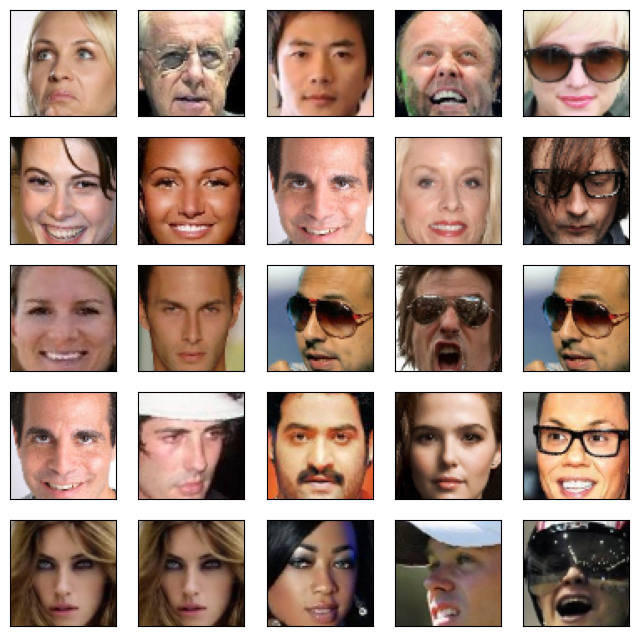

In [5]:
print('Let\'s view more faces. Looking at a bigger sample reveals something for the dataset...')
print('\nEven though this sample is randomly picked, most images (if not all) are of light skinned males and females. By law of big numbers this means that\
 certain ethnicity groups \nare overrepresented in the dataset. A classifier (like a CNN) can become algorithmically biased by this \
imbalance. For example the classifier could identify less \naccurately dark skinned males and females).\n')
show(face_images,25)

<h1> Let's train a standard CNN to do classification. </h1>

<justify>
The CNN model is trained to predict if a specific image depicts a face or doesn't. It's architecture follows the typical pattern, with several <b> convolutional layers + batch normalizations, followed by two fully connected  layers, one for flattening of the convolution output a dense layer for class prediction to the single output.</b>.
</justify>


In [6]:
def CNN_classifier(n_outputs=1): # Output is a single logit indicating face or no face.

    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
    # 1st CNN layer has 12 filters. For each filter and at each position, the
    # kernel computes a weighted sum of the input pixels by convolution within
    # its area and produces a single output pixel in the feature map. In our case,
    # this means each filter in the first layer produces a 32x32 feature map. (64/2=32)
    # Output is a tensor with shape (32,32,12)
    Conv2D(filters=1*12, kernel_size=5,  strides=2),
    # BatchNorm would normalize each of the 12 channels (feature maps) based
    # on the statistics of the current mini-batch.
    BatchNormalization(),

    #2nd CNN layer
    Conv2D(filters=2*12, kernel_size=5,  strides=2),
    BatchNormalization(),

    #3rd CNN layer
    Conv2D(filters=4*12, kernel_size=3,  strides=2),
    BatchNormalization(),

    #4th CNN layer
    Conv2D(filters=6*12, kernel_size=3,  strides=2),
    BatchNormalization(),

    #5th layer
    Flatten(), # This is how the algorithm "sees" the images.

    #6th layer
    Dense(512),

    #7th layer : Output is by default 1 dimensional,
    # no activation function means ouput is a logit.
    Dense(n_outputs, activation=None),

    ])

    return model

standard_classifier = CNN_classifier()

In [7]:
standard_classifier.predict(np.array([face_images[0]]))
standard_classifier.summary()

1/1 [==============================] - 1s 891ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 12)        912       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 12)       48        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 24)        7224      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 24)       96        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 48)          10416     
                                                                 
 ba

In [8]:
#some_faces = loader.get_batch(16+1)[0]
#plt.figure(figsize=(6,6))
#for i in range(16):
#    plt.subplot(4,4,i+1)
#    plt.xticks([])
#    plt.yticks([])
#   plt.grid(False)
#    plt.imshow(some_faces[i])#, cmap=plt.cm.binary)
#    plt.xlabel(round(standard_classifier.predict(np.array([some_faces[i]]))[0][0],3))
#plt.show()
#print('Some images and their predictions (single logits) using the untrained CNN.')

In [10]:
import time
from IPython import display as ipythondisplay

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [23]:
# Training of the CNN

batch_size = 1000
num_epochs = 1

learning_rate = 5e-4

# Adam is a "stochastic gradient descent type" optimizer.
# It change the weights of the innerconnected nodes in order to "surf down"
# the biggest descent in the multidimensional weight n-plane.
optimizer = tf.keras.optimizers.Adam(learning_rate)

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    logits = standard_classifier(x) # Output of classifer for batches x
    loss = tf.nn.sigmoid_cross_entropy_with_logits(y,logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables) # Derivative with respect to weights. (Multivariable and chained)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables)) # Sliding to the lowest point of an n-parameter landscape.
  return loss

# The training loop.
loss_history = []
times = round(int(loader.get_train_size()/2)//batch_size,-1)
for epoch in range(num_epochs):
     # I use a few iterations
    with tqdm(range(times), desc=f'Epoch {epoch+1}', dynamic_ncols=True) as pbar:
        for idx in pbar:
            # Grab a batch of training data and propagate through the network
            x, y = loader.get_batch(batch_size)
            loss = standard_train_step(x, y)
            loss_history.append(loss.numpy().mean())
            pbar.set_postfix(Loss = f'{loss.numpy().mean():.4f}', refresh=True)

Epoch 1: 100%|██████████| 50/50 [01:50<00:00,  2.20s/it, Loss=0.0514]

Loss =  0.051377784


In [24]:
# Pick more samples for testing. I can do that since total dataset size is 100k
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x))) # there is no activation function at CNN class I built
# tf.equal() compares
# tf.cast() transforms to type ( ,)
# tf.reduce_mean() find the average
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 8s 49ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9844



<p align='justify'>
<center><img src="https://i.imgflip.com/7vsslk.jpg
"  width="500"></center>

This is a good (excellent) performance. However the nn algorithm distinguishes faces from non faces by finding hidden (latent) characteristics (features) inside the pictures that we humans can't recognise at first glance. It's also important to remember that just because a neural network perceives more characteristics doesn't mean it's infallible. Since we can not perceive such characteristics and we are the ones who picked the sample, it is very probable that such characteristics are not equally stratified among the dataset and meaning we will sample an inbalanced dataset. This can lead to the training of a model that is algorithmically biased.
</p>


<h1> SOLUTIONS </h1>


A naive first approach (most usually done) would be to create different subclasses (i.e., light-skinned females, males with hats, females smiling etc.) within the training data, and then evaluate classifier performance with respect to these clustered groups. But there are two big problems with this. First, labeling lots of data that way takes a lot of time and effort. Second, we might miss out on some biases because we didn’t think of them when labeling like race, hats, glasses, etc.

<p align='justify'> <center><img src="https://www.thoughtco.com/thmb/DlzsYR0whBb3taEl45YTviOZtxM=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-11410491702-07f03ccd0eb54d36a9b62212cd2f55a1.jpg" width="400"></center>

A way to explain this metaphorically is by the allegory of Plato's Cave, where the prisoners can only recognise the shapes of objects while a freed man recognises more quintessential properties. In that case a prisoner and freed man would probably have different ways of recognizing objects and divide them in different groups. So in this case, we are the prisoners and the algorithm is the freed men! <br> Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in the training dataset are those of light-skinned females. As a result, a classifier trained that will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased, more technically the classiers' classification decision changes after it sees some additional latent features or variables. <br> **But is there a way to "learn" the distribution of these latent characteristics in an unbiased, unsupervised manner, without the need for any annotation and grouping? We can use VAEs!**
</p>



<div style="text-align: center"> <h1> The concept of VAEs</h1></div>

<justify> An autoencoder has two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation</justify>
<p align='justify'> <center><img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-16-at-10.24.11-PM.png" width="900"></center>

<justify> A variational autoencoder can be defined as being an autoencoder (an encoder followed by a decoder) whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.
</justify>

<center> <img src="https://i.ibb.co/3s4S6Gc/vae.jpg
"  width="700"/>
</center>

<justify>
The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization. Now we're ready to define our VAE loss function:
</justify>

In [13]:
# ARGUMENTS
# x : the true input
# x_recon : the iput that is encoded and then decoded using the VAE
# mu, logsigma : latent distribution characteristics

# RETURNS
# vae loss

def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):

  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss

  return vae_loss

<center><img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ejNnusxYrn1NRDZf4Kg2lw@2x.png"  width="1000"/>
</center>

VAEs use a "reparameterization  trick" for sampling learned latent variables. The VAE encoder generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample a noise value $\epsilon$ from a Gaussian distribution, and then scale it by the standard deviation and add back the mean to output the result as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim N(0,(I))$ we have:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [14]:
# ARGUMENTS
# z_mean
# z_logsigma

# RETURNS
# z:

def sampling(z_mean, z_logsigma):
  # random.normal is mean=0 and std=1.0
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

## Semi-supervised variational autoencoder (SS-VAE)

A VAE that has a supervised component in order to both output a classification decision for the facial detection task and analyze where the biases in our model may be resulting from. While previous works like that of  Buolamwini and Gebru have focused on skin tone and gender as two categories where facial detection models may be experiencing bias, there may be other unlabeled features that also are biased, resulting in poorer classification performance. We will build our semi-supervised VAE (SS-VAE) to learn these underlying latent features.

A general schematic of the SS-VAE architecture is shown here.

<center><img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/SS-VAE.png"  width="600"/>
</center>

We will apply our SS-VAE to a *supervised classification* problem -- the facial detection task. Importantly, note how the encoder portion in the SS-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction -- face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is the key distinction between the SS-VAE and a traditional VAE.

Keep in mind that we only want to learn the latent representation of *faces*, as that is where we are interested in uncovering potential biases, even though we are training a model on a binary classification problem. So, we will need to ensure that, **for faces**, our SS-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, and outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

### Defining the SS-VAE loss function

This means we'll need to be a bit clever about the loss function for the SS-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered.

For **face images**, our loss function will have two components:

1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem.

In contrast, for images of **non-faces**, our loss function is solely the classification loss.

We can write a single expression for the loss by defining an indicator variable ${I}_f$which reflects which training data are images of faces (${I}_f(y) = 1$ ) and which are images of non-faces (${I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + {I}_f(y)\Big[L_{VAE}\Big]$$

Let's write a function to define the SS-VAE loss function:


In [15]:
# ARGUMENTS
# x: true input x
# x_pred: reconstructed x
# y: true label (face or not face)
# y_logit: predicted labels
# mu: mean of latent distribution (Q(z|X))
# logsigma: log of standard deviation of latent distribution (Q(z|X))

# RETURNS
# total_loss: SS-VAE total loss
# classification_loss: SS-VAE classification loss

def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(y,y_logit)
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32) # This is I_f(y) = 1 or 0

    # tf.reduce_mean to average over all samples
    total_loss = tf.reduce_mean(classification_loss + face_indicator * vae_loss)
    return total_loss, classification_loss, vae_loss

<p align='justify'>
Defining the SS-VAE architecture
Now we're ready to define the SS-VAE architecture. To build the SS-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the encoder and decoder networks, and then construct the end-to-end VAE. We will use a latent space with 32 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image. </p>

In [16]:
### DECODER PART OF SS-VAE ###

def make_face_decoder_network(n_filters=12):

    # Functionally define the different layer types we will use
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape


    decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)

    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder before)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
    ])

    return decoder

## Let's put encoder and decoder together. ##

In [25]:
### Defining and creating the SS-VAE ###

class SS_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = CNN_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder (self.decoder) to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    z = sampling(z_mean, z_logsigma)

    recon = self.decode(z)

    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

ss_vae = SS_VAE(latent_dim=32)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


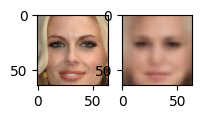

 15%|█▍        | 500/3434 [01:06<08:51,  5.52it/s]

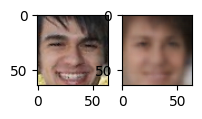

 29%|██▉       | 1000/3434 [02:13<04:56,  8.21it/s]

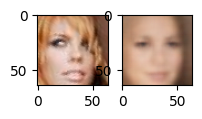

 44%|████▎     | 1500/3434 [03:20<04:01,  7.99it/s]

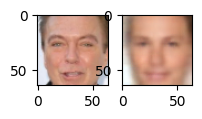

 58%|█████▊    | 2000/3434 [04:27<03:08,  7.61it/s]

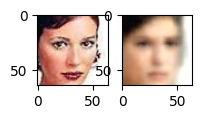

 73%|███████▎  | 2500/3434 [05:35<01:57,  7.95it/s]

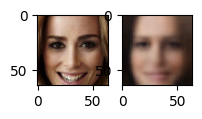

 87%|████████▋ | 3000/3434 [06:43<00:54,  7.90it/s]

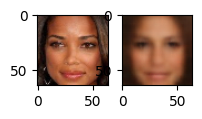

100%|██████████| 3434/3434 [07:42<00:00,  7.43it/s]


In [26]:
### Training the SS-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32

# SS-VAE needs slightly more epochs to train since its more complex than
# the standard classifier so we use 6 instead of 2
num_epochs = 6

# instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def ss_vae_train_step(x, y):

    with tf.GradientTape() as tape:
        y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
        loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

    grads = tape.gradient(loss, ss_vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))

    return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # get a batch of training data and compute the training step
  #for j in tqdm(range(10000 // batch_size)):
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size)
    # loss optimization
    loss = ss_vae_train_step(x, y)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, ss_vae)

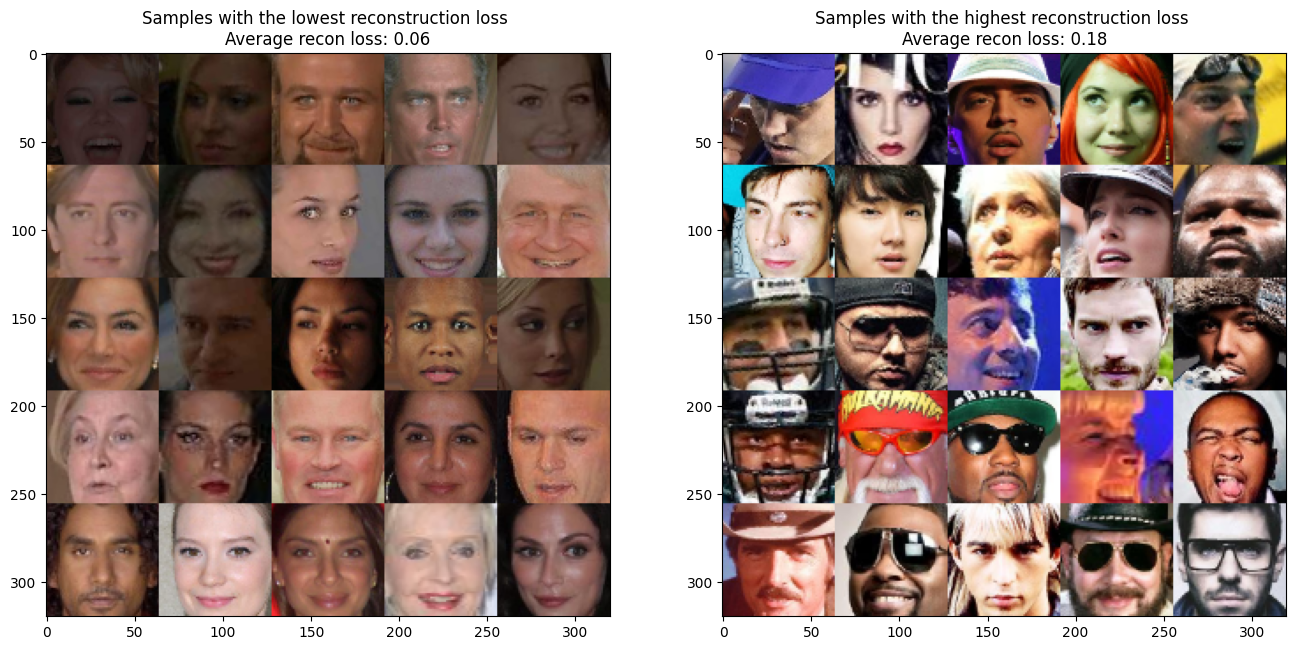

In [29]:


### Linking model performance to uncertainty and bias

# Load a random sample of 5000 faces from our dataset and compute the model performance on them
(x, y) = loader.get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the vae loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

# Plot the 25 samples with the highest and lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

In [30]:
from ipywidgets import interact

def inspect_latent_features(idx_latent=21):
    num_steps = 15

    # Extract all latent samples from the desired dimension
    latent_samples = z_mean[:, idx_latent]

    # Compute their density and plot
    density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
    fig, ax = plt.subplots(2, 1, figsize=(15, 4))
    ax[0].bar(latent_bins[1:], density)
    ax[0].set_ylabel("Data density")

    # Visualize reconstructions as we walk across the latent space
    latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
    baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

    recons = []
    for step in latent_steps:
        # Adjust the latent vector according to our step
        latent = baseline_latent.numpy()
        latent[0, idx_latent] = step
        # Decode the reconstruction and store
        recons.append(ss_vae.decode(latent)[0])

    # Visualize all of the reconstructions!
    ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
    ax[1].set_xlabel("Latent step")
    ax[1].set_ylabel("Visualization")
    plt.show()

# Create an interactive slider below the cell
interact(inspect_latent_features, idx_latent=(0, 31, 1));


interactive(children=(IntSlider(value=21, description='idx_latent', max=31), Output()), _dom_classes=('widget-…

Text(0, 0.5, 'Relative accuracy')

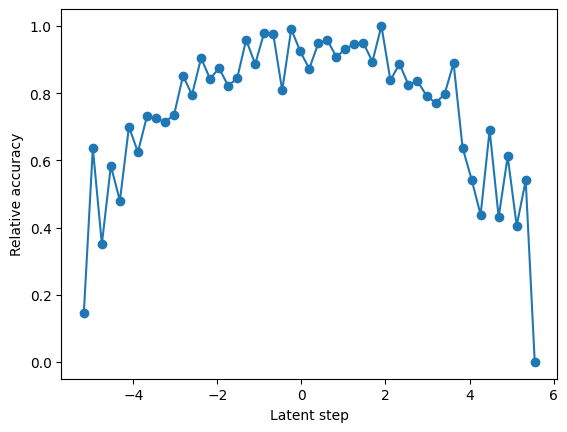

In [34]:
### Accuracy vs. density in latent space

# Loop through every latent dimension
avg_logit_per_bin = []
num_steps = 50
for idx_latent in range(latent_dim):
    latent_samples = z_mean[:, idx_latent]
    start = np.percentile(latent_samples, 5)
    end = np.percentile(latent_samples, 95)
    latent_steps = np.linspace(start, end, num_steps)

    # Find which samples fall in which bin of the latent dimension
    which_latent_bin = np.digitize(latent_samples, latent_steps)

    # For each latent bin, compute the accuracy (average logit score)
    avg_logit = []
    for j in range(0, num_steps+1):
      inds_in_bin = np.where(which_latent_bin == j)
      avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

    avg_logit_per_bin.append(avg_logit)

# Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")